### Продвинутая визуализация данных. Задания 4
В этот раз нам нужно создать визуализации результатов работы алгоритмов обучения с учителем и без учителя, проанализировать изменения параметров и ROC-кривых при изменении гиперпараметров модели, обсудить различия в результатах работы моделей.

Мы будем работать с тремя датасетами. Перед каждым заданием будет его описание.

Не пугайтесь количеству импортированных библиотек — это шпаргалка со всеми библиотеками, которые мы использовали в четвертом модуле. В этом задании мы будем использовать несколько из них.

In [89]:
#импорт библиотек

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from IPython.display import clear_output
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import pairwise_distances_argmin_min
from pyod.models.hbos import HBOS
import time
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score

Первый датасет — данные по весу и росту в зависимости от пола. В нем нет разметки, поэтому необходимо использовать методы обучения без учителя.

Импортируем датасет и визуально посмотрим на него перед началом работы:

In [90]:
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


In [91]:
weight_height.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


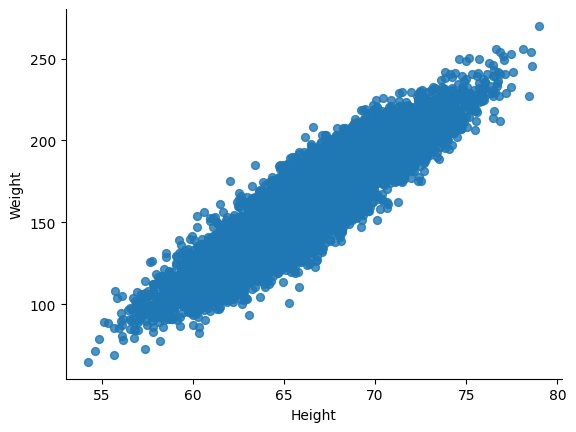

In [92]:
weight_height.plot(kind='scatter', x='Height', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### Задание 1. Сравнение моделей обучения с учителем (4 балла)
Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (scatter plot) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

Interquartile range (IQR) — возьмите выбросы по x и y.
Isolation forest.
Local Outlier Factor.
One-class SVM.
Gaussian Mixture.
DBSCAN.
Напишите, какие модели показали себя лучше всего и почему.

Критерии оценивания:

1 балл за каждую правильно построенную модель и корректно выведенные выбросы (всего 3 балла).
1 балл за правильное оформление графиков и полотна графиков.

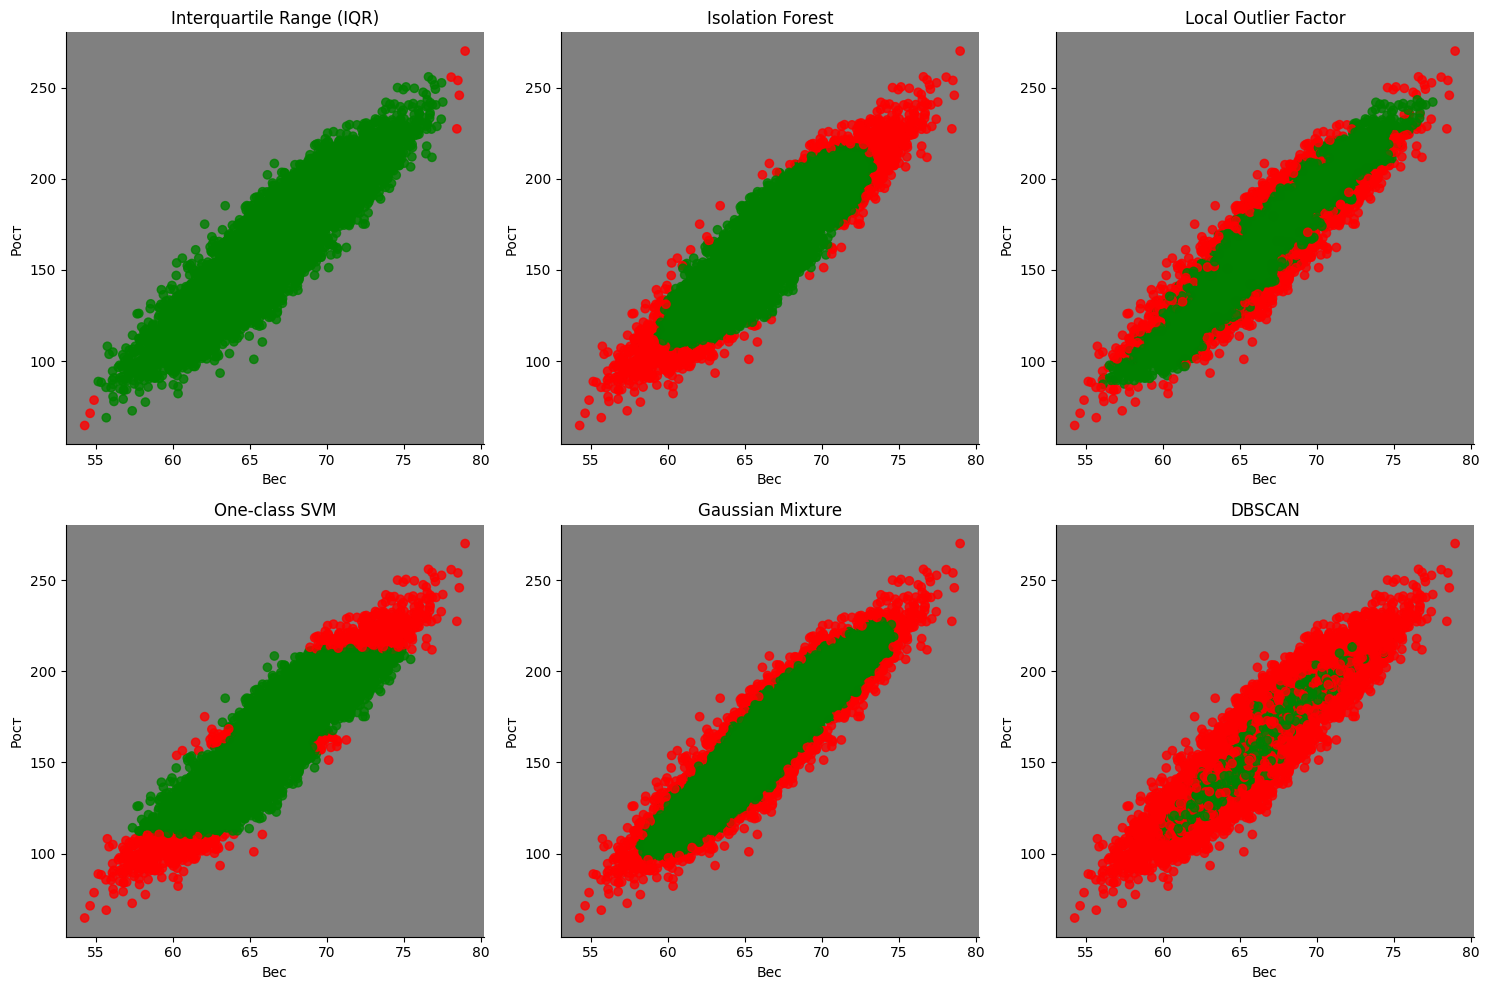

In [93]:
df = weight_height[['Height','Weight']]

#Построение графиков
title_lst = ['Interquartile Range (IQR)', 'Isolation Forest', 'Local Outlier Factor', 'One-class SVM', 'Gaussian Mixture', 'DBSCAN']
algoritm_lst = []

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Interquartile Range (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
iqr_algoritm = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

# Isolation Forest
isol_forest = IsolationForest(contamination=0.1)
isol_forest.fit(df)
isol_forest_algoritm = isol_forest.predict(df) == -1

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_algoritm = lof.fit_predict(df) == -1

# One-class SVM
oc_svm = OneClassSVM(nu=0.1)
oc_svm.fit(df)
oc_svm_algoritm = oc_svm.predict(df) == -1

# Gaussian Mixture
gaus_mix = GaussianMixture(n_components=2, covariance_type='full')
gaus_mix.fit(df)
gaus_mix_algoritm = gaus_mix.score_samples(df) < -8

# DBSCAN
db_scan = DBSCAN(eps=0.2, min_samples=5)
db_scan_algoritm = db_scan.fit_predict(df) == -1


algoritm_lst.append(iqr_algoritm)
algoritm_lst.append(isol_forest_algoritm)
algoritm_lst.append(lof_algoritm)
algoritm_lst.append(oc_svm_algoritm)
algoritm_lst.append(gaus_mix_algoritm)
algoritm_lst.append(db_scan_algoritm)

for ax, algoritm, title in zip(axs.flat, algoritm_lst, title_lst):
    ax.scatter(df['Height'], df['Weight'], c=np.where(algoritm, 'red', 'green'), alpha=0.8)
    ax.set_facecolor("gray")
    ax.set_title(title)
    ax.set_xlabel('Вес')
    ax.set_ylabel('Рост')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Задания 2 и 3
Используя датасет, определите оптимальные параметры модели Isolation Forest с помощью кросс-валидации.

Наш датасет — это набор данных, первоначально взятый из набора данных UCI о заболеваниях щитовидной железы. Он содержит 16 категориальных атрибутов, 5 числовых атрибутов и 1 целевой атрибут. Всего — 22 атрибута.

### Задание 2. Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
После обучения модели выполните следующее:

Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в sklearn.model_selection.GridSearchCV). В GridSearchCV используйте params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}.
Сделайте предсказания на данных Х.
Поиграйте с параметром n_jobs — создайте 6 разных визуализаций с параметрами от 1 до 6.
Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).
Критерии оценивания:

1 балл за правильное использование GridSearchCV для подбора параметров в IsolationForest.
2 балла за правильный вывод параметров для шести моделей с разным параметром n_jobs.

In [94]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


In [95]:
thyroid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6916 entries, 0 to 6915
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6916 non-null   float64
 1   Sex                        6916 non-null   float64
 2   on_thyroxine               6916 non-null   float64
 3   query_on_thyroxine         6916 non-null   float64
 4   on_antithyroid_medication  6916 non-null   float64
 5   sick                       6916 non-null   float64
 6   pregnant                   6916 non-null   float64
 7   thyroid_surgery            6916 non-null   float64
 8   I131_treatment             6916 non-null   float64
 9   query_hypothyroid          6916 non-null   float64
 10  query_hyperthyroid         6916 non-null   float64
 11  lithium                    6916 non-null   float64
 12  goitre                     6916 non-null   float64
 13  tumor                      6916 non-null   float

In [96]:
thyroid.describe()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,lithium,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured
count,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,...,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000
mean,0.595098,0.307548,0.134615,0.015616,0.013158,0.038317,0.011278,0.014315,0.016773,0.062753,...,0.013013,0.008531,0.025448,0.000145,0.049740,1.603466,11.772446,94.253834,88.270139,95.257058
std,6.189326,0.461512,0.341337,0.123993,0.113959,0.191974,0.105606,0.118793,0.128428,0.242536,...,0.113339,0.091975,0.157494,0.012025,0.217422,14.047218,11.836250,50.555642,33.909845,55.031137
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.002500,0.050000,0.002400
25%,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000680,0.020100,77.000000,83.000000,81.000000
50%,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001700,13.000000,101.000000,96.000000,105.000000
75%,0.670000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002700,22.000000,123.000000,104.000000,125.000000
max,515.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,494.000000,95.000000,395.000000,233.000000,642.000000


In [97]:
thyroid['Outlier_label '].value_counts()

Outlier_label 
n    6666
o     250
Name: count, dtype: int64

In [98]:
df=thyroid.copy()

#категориальные,числовые и целевая переменные
categor = ['Sex', 'on_thyroxine', 'query_on_thyroxine',
               'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
               'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
               'goitre', 'tumor', 'hypopituitary', 'psych']
num = ['Age', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured']

target = 'Outlier_label '

#предобработка данных
X = df[categor + num]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
processor = ColumnTransformer(transformers=[('num', StandardScaler(), num), ('cat', OneHotEncoder(), categor)])
X_train_proces = processor.fit_transform(X_train)
X_test_proces = processor.transform(X_test)

#диапазоны параметров
n_estimators_range = [100, 200, 300]
max_samples_range = ['auto', 0.5, 0.75, 1.0]
contamination_range = ['auto', 0.1, 0.2, 0.3]
max_features_range = [0.5, 0.75, 1.0]
bootstrap_options = [True, False]

best_score = -1
best_params = {}

y_true_convert = y_test.map({'o': -1, 'n': 1}).values                      
                        
#перебор гиперпараметров
for n_estimators in n_estimators_range:
    for max_samples in max_samples_range:
        for contamination in contamination_range:
            for max_features in max_features_range:
                for bootstrap in bootstrap_options:
                    model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, max_features=max_features, bootstrap=bootstrap, random_state=42)
                    model.fit(X_train_proces, y_train)
                    y_pred = model.predict(X_test_proces)
                    score = f1_score(y_true_convert, y_pred, average='macro')
                    if score > best_score:
                        best_score = score
                        best_params = {'n_estimators': n_estimators, 'max_samples': max_samples, 'contamination': contamination, 'max_features': max_features, 'bootstrap': bootstrap}
                        clear_output(wait=True)
                        print(f'Best score: {best_score}')
                        print(f'Best parameters: {best_params}')
                        time.sleep(0.5)

                    
                        
                        
#обучение модели
best_model = IsolationForest(**best_params, random_state=42)
best_model.fit(X_train_proces, y_train)
y_pred = best_model.predict(X_test_proces)

#вывод результата
print(classification_report(y_true_convert, y_pred))

Best score: 0.4986043590920226
Best parameters: {'n_estimators': 200, 'max_samples': 0.75, 'contamination': 'auto', 'max_features': 0.5, 'bootstrap': False}
              precision    recall  f1-score   support

          -1       0.04      0.03      0.04        58
           1       0.96      0.96      0.96      1326

    accuracy                           0.92      1384
   macro avg       0.50      0.50      0.50      1384
weighted avg       0.92      0.92      0.92      1384



n_jobs=1: ['normal' 'normal' 'outlier' 'normal' 'normal']
n_jobs=2: ['normal' 'normal' 'outlier' 'normal' 'normal']
n_jobs=3: ['normal' 'normal' 'outlier' 'normal' 'normal']
n_jobs=4: ['normal' 'normal' 'outlier' 'normal' 'normal']
n_jobs=5: ['normal' 'normal' 'outlier' 'normal' 'normal']
n_jobs=6: ['normal' 'normal' 'outlier' 'normal' 'normal']


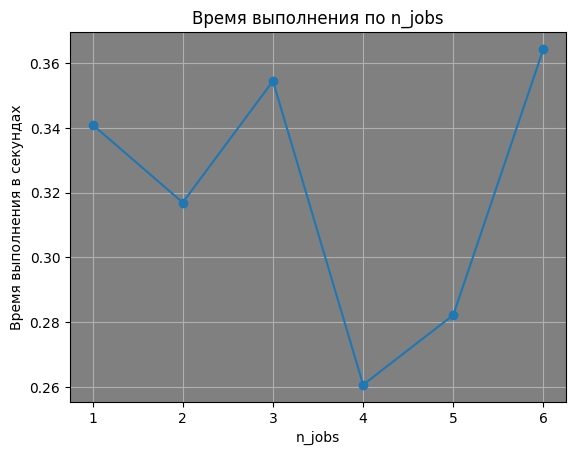

In [117]:
#использование оптимальных параметров
best_params = {'n_estimators': 200, 'max_samples': 0.75, 'contamination': 'auto', 'max_features': 0.5, 'bootstrap': False}

execut_time_lst = []
n_jobs_range = range(1, 7)

for n_jobs in n_jobs_range:
    start_time = time.time()
    
    #обучение модели IsolationForest с n_jobs
    model = IsolationForest(n_estimators=best_params['n_estimators'],
                            max_samples=best_params['max_samples'],
                            contamination=best_params['contamination'],
                            max_features=best_params['max_features'],
                            bootstrap=best_params['bootstrap'],
                            n_jobs=n_jobs,
                            random_state=42)
    model.fit(X)
    
    
    end_time = time.time()
    execut_time_lst.append(end_time - start_time)

    y_pred = model.predict(X)
    y_pred_transformed = np.where(y_pred == 1, 'normal', 'outlier')
    print(f"n_jobs={n_jobs}: {y_pred_transformed[:5]}")

ax = plt.axes()
ax.set_facecolor("gray")
plt.plot(n_jobs_range, execut_time_lst, marker='o')
plt.title('Время выполнения по n_jobs')
plt.xlabel('n_jobs')
plt.ylabel('Время выполнения в секундах')
plt.xticks(n_jobs_range)
plt.grid(True)
plt.show()

Результаты для n_jobs=1:
Предсказание: ['normal' 'normal' 'outlier' 'normal' 'normal']


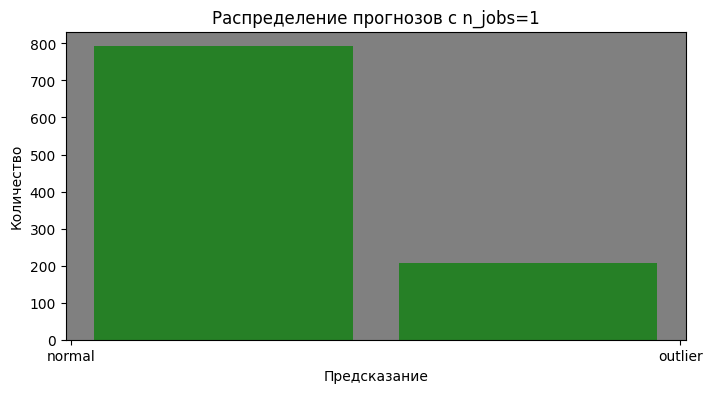

Результаты для n_jobs=2:
Предсказание: ['normal' 'normal' 'outlier' 'normal' 'normal']


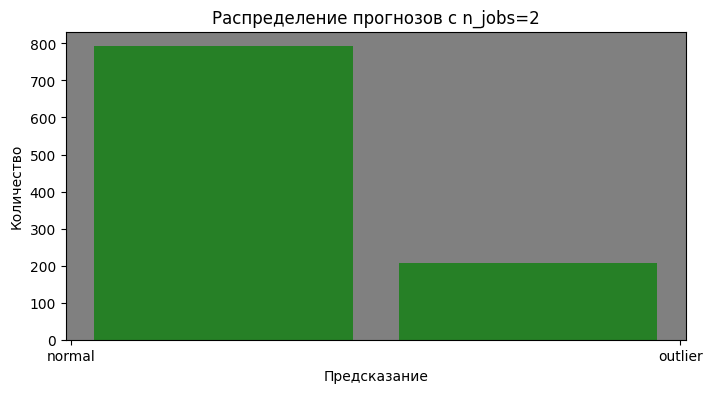

Результаты для n_jobs=3:
Предсказание: ['normal' 'normal' 'outlier' 'normal' 'normal']


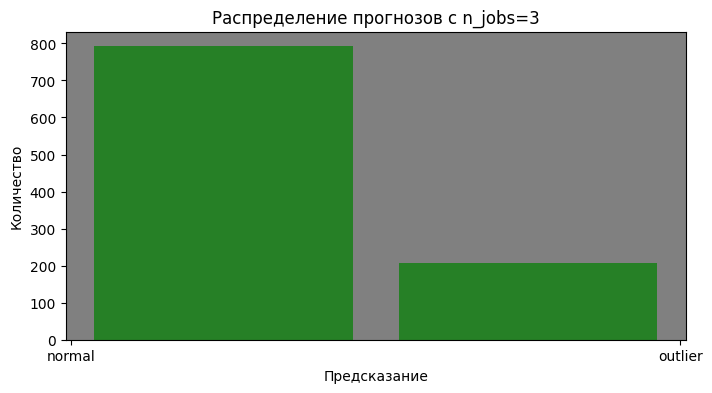

Результаты для n_jobs=4:
Предсказание: ['normal' 'normal' 'outlier' 'normal' 'normal']


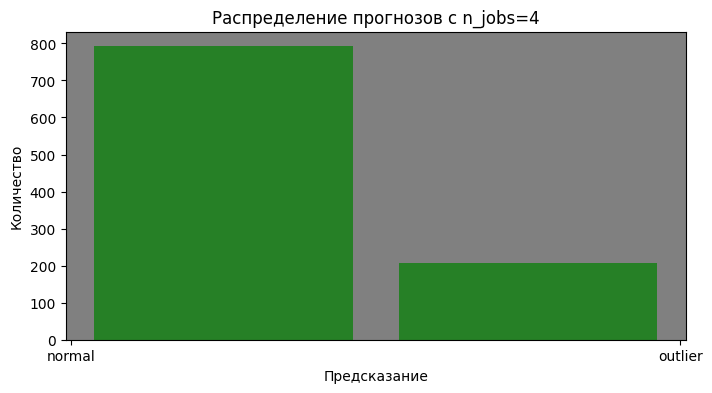

Результаты для n_jobs=5:
Предсказание: ['normal' 'normal' 'outlier' 'normal' 'normal']


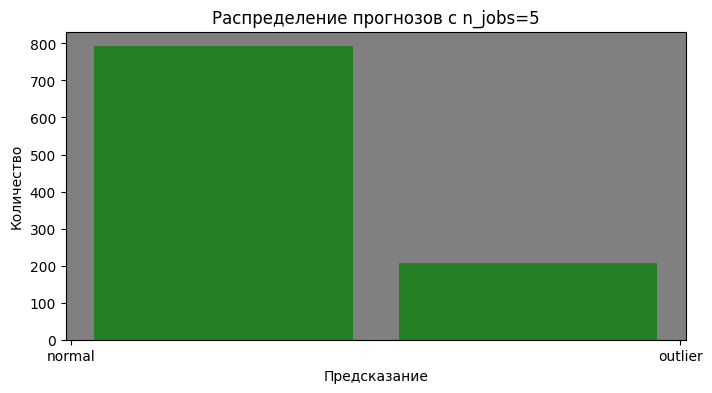

Результаты для n_jobs=6:
Предсказание: ['normal' 'normal' 'outlier' 'normal' 'normal']


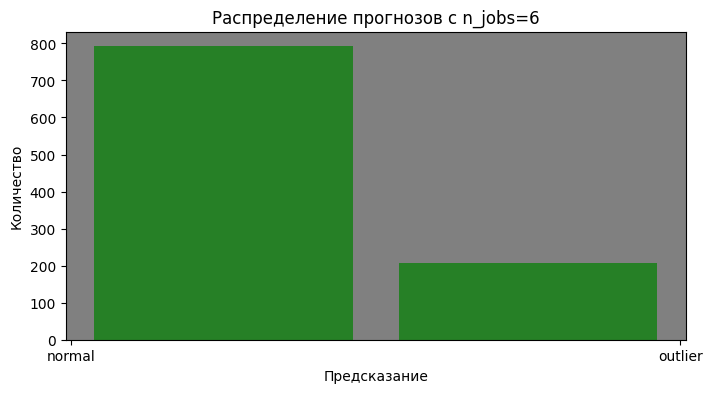

In [119]:
#лучшие параметры
best_params = {
    'n_estimators': 200,
    'max_samples': 0.75,
    'contamination': 'auto',
    'max_features': 0.5,
    'bootstrap': False
}

#оценка модели Isolation Forest с различными значениями n_jobs
for n_jobs in range(1, 7):
    model = IsolationForest(n_estimators=best_params['n_estimators'],
                            max_samples=best_params['max_samples'],
                            contamination=best_params['contamination'],
                            max_features=best_params['max_features'],
                            bootstrap=best_params['bootstrap'],
                            n_jobs=n_jobs,
                            random_state=42)
    
   
    model.fit(X)
    y_pred = model.predict(X)
    y_pred_transform = np.where(y_pred == 1, 'normal', 'outlier')
    
    #вывод результатов
    print(f"Результаты для n_jobs={n_jobs}:")
    print(f"Предсказание: {y_pred_transform[:5]}")
    
    plt.figure(figsize=(8, 4))
    ax = plt.axes()
    ax.set_facecolor("gray")
    plt.hist(y_pred_transformed, bins=2, color='green', alpha=0.7, rwidth=0.85, label=['Outlier', 'Normal'])
    plt.title(f"Распределение прогнозов с n_jobs={n_jobs}")
    plt.ylabel('Количество')
    plt.xlabel('Предсказание')
    plt.xticks(['normal', 'outlier'])
    plt.show()

### Задание 3. Визуализация ROC-кривой в зависимости от параметров Isolation Forest (3 балла)
Для каждого Isolation Forest создайте отдельную roc_curve и полотно с шестью графиками для визуализации шести ROC-кривых в зависимости от параметра n_jobs.

В название каждого графика выведите F1-score, Precision и Recall для каждой модели Isolation Forest.

Критерии оценивания:

2 балла за правильно построенные визуализации ROC-кривой.
1 балл за вывод правильных F1-score, Precision, Recall.

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ran

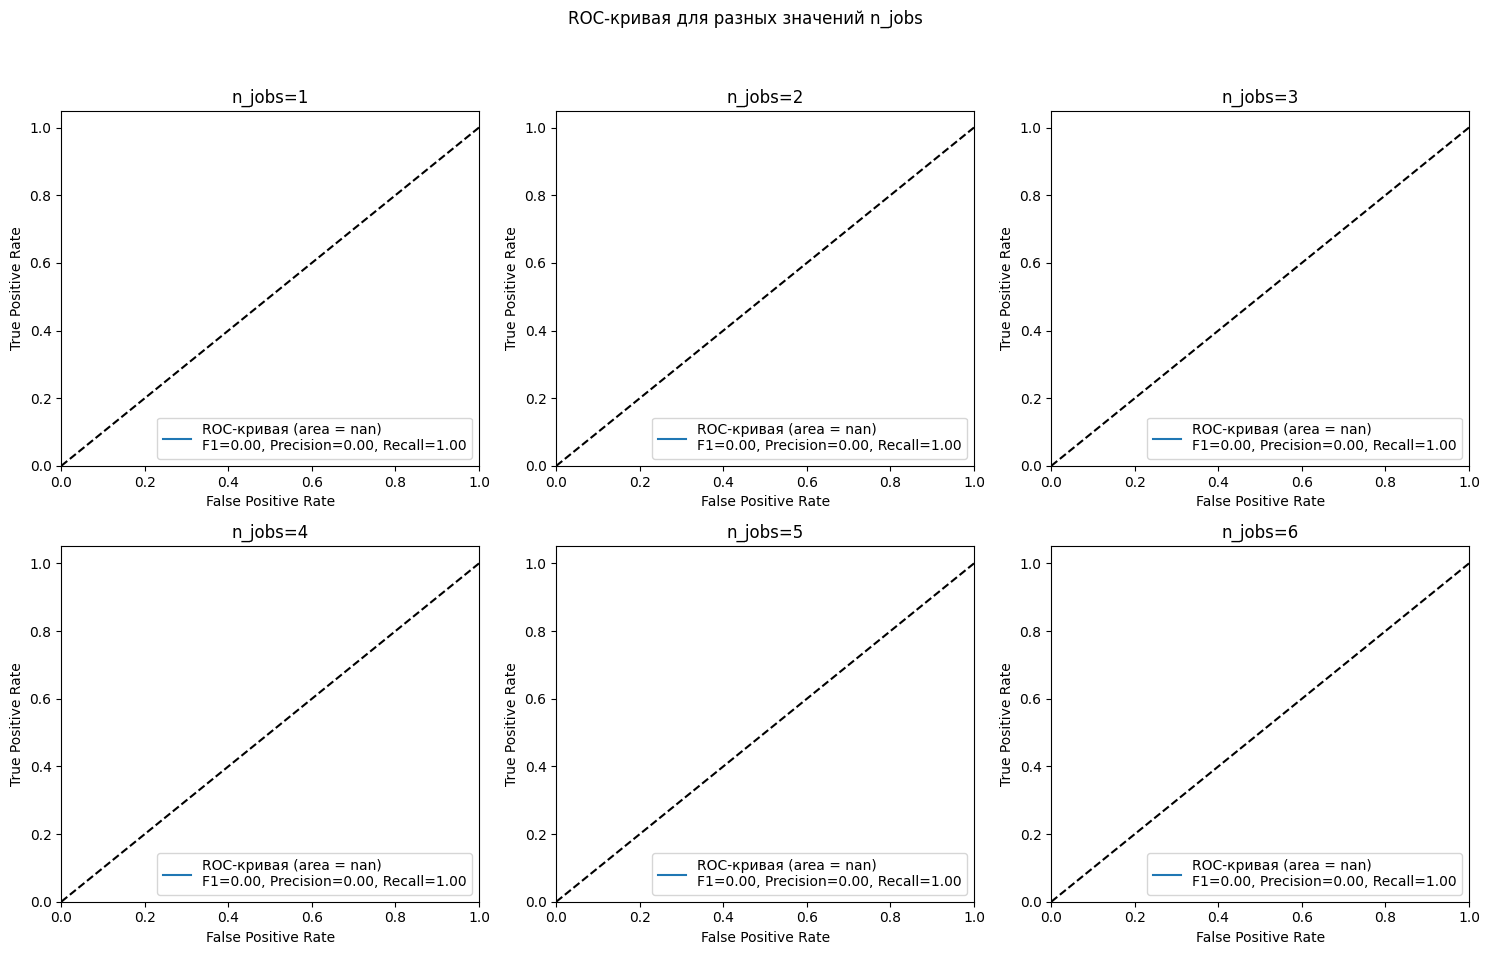

In [120]:
#считаем выбросы положительным классом (1), нормальные наблюдения - негативным (0)
y_true_bin = np.where(y_test == 'o', 1, 0)

n_jobs_values = range(1, 7)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('ROC-кривая для разных значений n_jobs')
#ax = plt.axes()
#ax.set_facecolor("gray")

for i, n_jobs in enumerate(n_jobs_values):
    
    model = IsolationForest(random_state=42, **best_params)
    model.fit(X_train)

    scores_pred = model.decision_function(X_test)
    
    assert len(y_true_bin) == len(scores_pred), "Размеры y_true_binary и scores_pred не совпадают"

    #метрики
    fpr, tpr, thresholds = roc_curve(y_true_bin, scores_pred)
    roc_auc = auc(fpr, tpr)
    y_pred = model.predict(X_test)
    y_pred_bin = np.where(y_pred == -1, 1, 0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=1)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=1)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=1)
    
    ax = axs[i // 3, i % 3]
    ax.plot(fpr, tpr, label=f'ROC-кривая (area = {roc_auc:.2f})\nF1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'n_jobs={n_jobs}')
    ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Задание 4. Проверка эффективности моделей без учителя (4 балла)
Ранее мы обсуждали, что методы обучения с учителем можно использовать не только для поиска аномалий, но и для классической классификации. Аналогично первому заданию, используя разные алгоритмы обучения с учителем, постройте модель для классификации по данным датасета.

Наш третий датасет — данные по принятым и не принятым в университет студентам в зависимости от их среднего балла и балла за экзамен. В качестве переменных для анализа используйте средний балл (cgpa) и балл за экзамен (placement_exam_marks), а в качестве зависимой переменной в кластеризации используйте переменную placed.

Создайте поле из шести графиков. Каждый график должен представлять собой confusion_matrix (heatmap или тепловую карту) с попаданиями модели (матрица 2 на 2 с попаданиями модели, как делали на третьей неделе). Каждый график должен иметь заголовок и названия полей. На тепловой карте на каждом квадратике должно быть указано число, а также colorbar с правой стороны.

Поместите на графики следующие 6 алгоритмов:

k-Nearest Neighbors (KNN).
SVM (Support Vector Machine).
Random Forest.
AdaBoost.
Gradient Boosting.
Decision Tree.
Критерии оценивания:

1 балл за каждые 2 правильно построенные модели и корректно выведенные выбросы.
1 балл за правильное оформление графиков и полотна графиков.

In [102]:
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head()

,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1
3,6.42,8.0,1
4,7.23,17.0,0


KNN Classification Report:
              precision    recall  f1-score   support
0              0.765286  0.759295  0.762279   511.000
1              0.750507  0.756646  0.753564   489.000
accuracy       0.758000  0.758000  0.758000     0.758
macro avg      0.757897  0.757971  0.757922  1000.000
weighted avg   0.758059  0.758000  0.758017  1000.000


SVM Classification Report:
              precision    recall  f1-score   support
0              0.516854  0.810176  0.631098   511.000
1              0.512563  0.208589  0.296512   489.000
accuracy       0.516000  0.516000  0.516000     0.516
macro avg      0.514708  0.509383  0.463805  1000.000
weighted avg   0.514756  0.516000  0.467485  1000.000


Random Forest Classification Report:
              precision    recall  f1-score   support
0              0.986220  0.980431  0.983317   511.000
1              0.979675  0.985685  0.982671   489.000
accuracy       0.983000  0.983000  0.983000     0.983
macro avg      0.982948  0.983058  0.9829

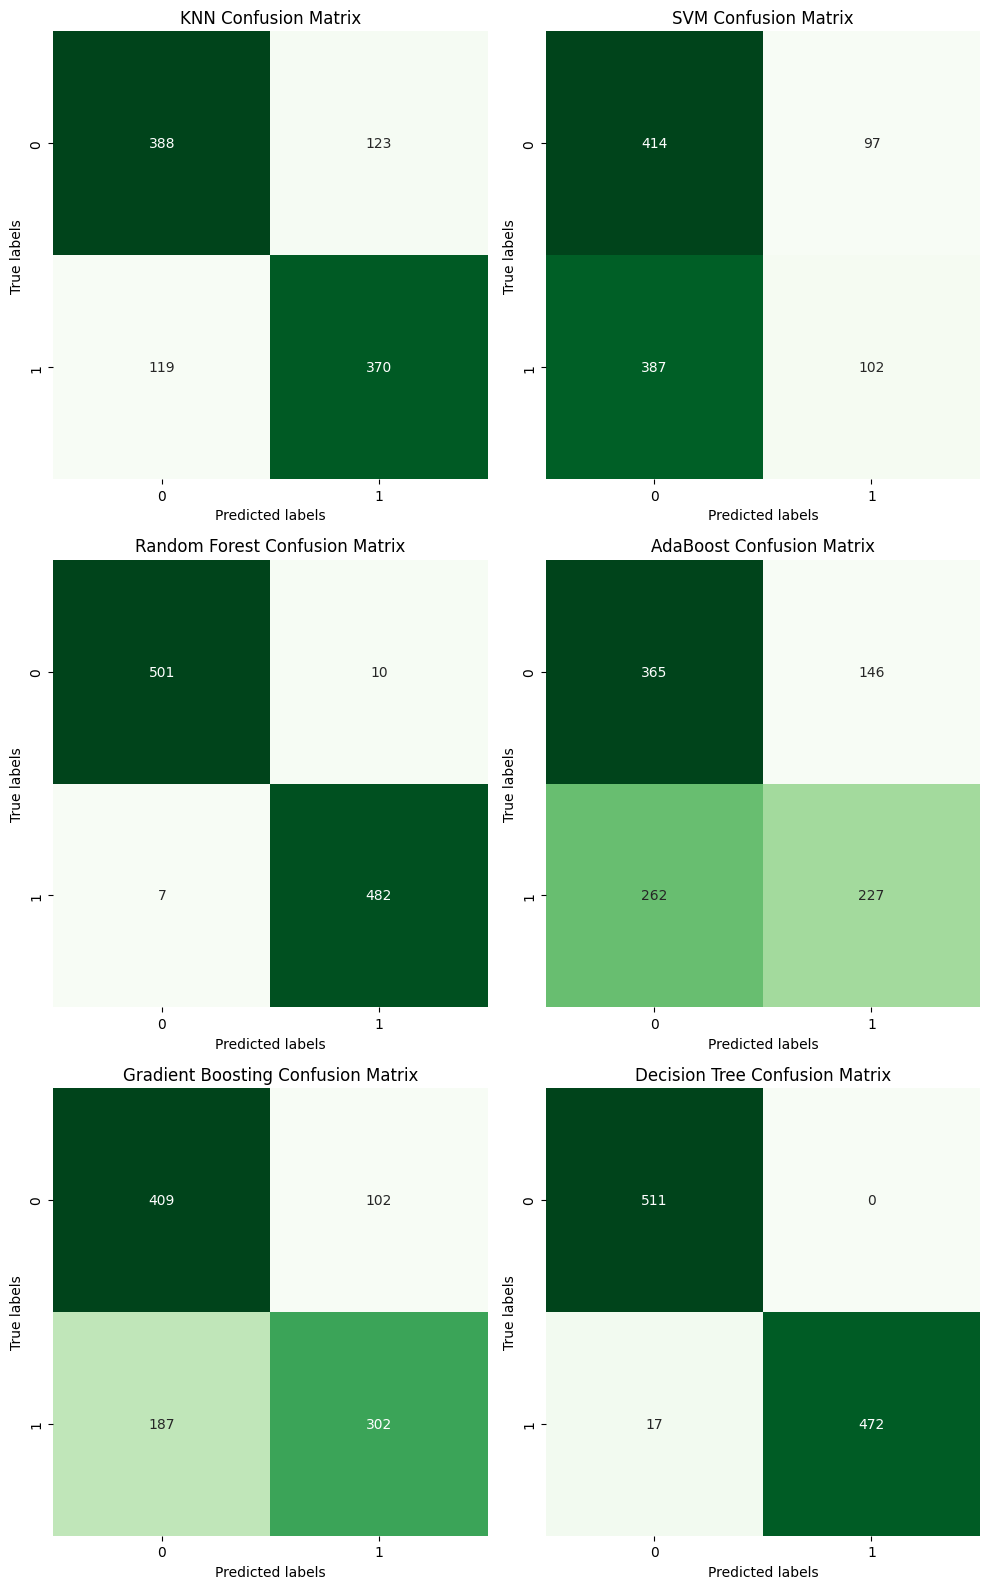

In [103]:
df=placement.copy()
X = df[['cgpa', 'placement_exam_marks']]
y = df['placed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'KNN': KNeighborsClassifier(n_neighbors=min(3, len(X))),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}


fig, axes = plt.subplots(3, 2, figsize=(10, 16))
axes = axes.flatten()
for ax, (name, model) in zip(axes, models.items()):
    model.fit(X, y)
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap='Greens', cbar=False)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    #отчет
    report = classification_report(y, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(f"{name} Classification Report:")
    print(df_report)
    print("\n")

plt.tight_layout()
plt.show()